# Aqwa File Reader

## Importing modules

In [1]:
import os
import sys
import pickle

import numpy as np

from zipfile import ZipFile as zips

import matplotlib.pyplot as plt

## Defining necessary functions

### I/O and conversions

In [2]:
def readmat(Lines,ib,ie):
    ##### Reading Matrices from AH1 file
    cs =((8,80))
    mu = []
    for line in Lines[ib:ie]:
        mu=np.append(mu,np.array(line[cs[0]:cs[1]].split(),dtype=np.float64))
    return mu

def findbeg(Lines,rStr):
    ##### Finding Beginning of Parameter in AH1 file
    c,ib=0,0
    for l in Lines:
        if l.strip()==rStr:
            ib=c
            break
        c=c+1
    return ib+1

def dumpkl(dcon,dqtf,ofnm):
    #### Building dictionary for export to pickle
    dall = dcon.update(dqtf)

def to_float(txt,STR):
    #### File name components to value
    #### 'D' - wave direction,'V' - vessel velocity,'B' - drift angle
    ind = txt.index(STR)
    return (float(txt[ind+1:ind+4]))


### Plotting funcitons

In [3]:
def plo_lin(dcon,ind):
    im,iv,ib = ind

    cNam = ['a','b']
    TIT = r'$\mu=%.1f^\circ$%6s$V_S=%.1f$ knots%6s$\beta=%.1f^\circ$'%(dcon['mu'][im],'',dcon['vs'][iv],'',dcon['bet'][ib])

    vfig = []
    for cn in cNam:
        fig,ax = plt.subplots(6,6,figsize=(12,9),sharex='all')
        fig.suptitle(TIT)
        for i in range(6):
            for j in range(6):
                arr = dcon[cn][im,iv,ib,:,i,j]
                #print(cn,dcon[cn].shape)
                #print(dcon['f1e'].shape)
                om = np.real(dcon['f1e'][im,iv,ib,:,-1])
                #om = dcon['fa'][im,iv,ib,:,0,0,:]
                ax[i,j].set_title(r'$'+cn+'_{%i%i}$'%(i+1,j+1))
                ax[i,j].plot(om,arr,lw=2,c='k')
                ax[i,j].set_xscale('log')
                ax[i,j].ticklabel_format(axis='y',useMathText=True,scilimits=(0,0))
                ax[i,j].set_xlabel(r'$\omega$ (rad/s)')
        fig.tight_layout()
        vfig.append(fig)
    return vfig

def plo_map(dcon,ind,cMap):
    im,iv = ind
    cNam = ['a','b']
    TIT = r'$\mu=%.1f^\circ$%6s$V_S=%.1f$ knots'%(dcon['mu'][im],'',dcon['vs'][iv])
    vfig = []
    for cn in cNam:
        fig,ax = plt.subplots(6,6,figsize=(12,9),sharex='all',sharey='all')
        fig.suptitle(TIT)
        for i in range(6):
            for j in range(6):
                arr = dcon[cn][im,iv,:,:,i,j]
                om = np.real(dcon['f1e'][im,iv,:,:,-1])
                bg = np.repeat(np.array(dcon['bet']),om.shape[1]).reshape(-1,om.shape[1])
                ax[i,j].set_title(r'$'+cn+'_{%i%i}$'%(i+1,j+1))
                ax[i,j].contourf(om,bg,arr,cmap=cMap)
                if j==0:
                    ax[i,j].set_ylabel(r'$\beta$')
                ax[i,j].yaxis.set_major_formatter(r'${x:.0f}^\circ$')
                if i == 5:
                    ax[i,j].set_xlabel(r'$\omega$ (rad/s)')
        fig.tight_layout()
        vfig.append(fig)
    return vfig

## Reading ZIP file inlcuding AQWA results

In [4]:
iDir = 'input/'
oDir = 'pkl/'

fnm = 'OMG_aqwa.zip'
SUF = fnm[:3]

Ma,Aa,Ba,Ca = [],[],[],[]
Qa,Fa = [],[]

fah1,fqtf = [],[]
with zips(iDir + fnm,'r') as zf:
    zf.extractall(iDir)
    for a in zf.infolist():
        afnm = a.filename
        if afnm[-3:] == 'AH1':
            fah1.append(afnm)
        else:
            fqtf.append(afnm)

## Building matrices of AQWA results
1. *M*: mass/inertia
2. *C*: stifness
3. *A*: added mass
4. *B*: damping
5. *F*: diffraction and Froude-Krylov forces (first order, complex numbers)
6. *Q*: near-field second order drift forces

In [5]:
VS,MU,BETA = [],[],[]
for fnam in fah1:

    VS   = np.append(VS,to_float(fnam,'V')/10.)
    MU   = np.append(MU,to_float(fnam,'D'))
    BETA = np.append(BETA,to_float(fnam,'B'))

    file = open(iDir + fnam, 'r')
    Lines = file.readlines()
    file.close()

    il =0
    while Lines[il][0] == '*':
        il+=1

    line=str(Lines[il:il+1])

    nd = int(line[4:6])
    nf = int(line[6:9])


    mu_c = int(np.ceil(nd/6))+1
    om_c = mu_c + int(np.ceil(nf/6))+1

    mu,om = [],[]

    if nd>1:
        mu = readmat(Lines,1,mu_c)
    else:
        mu = float(line[10:20])
        mu_c = 3
        om_c = om_c+1

    om = readmat(Lines,mu_c+1,om_c)

    mStr,cStr,aStr,bStr,fStr,qStr = 'MASS','HYDSTIFFNESS','ADDEDMASS','DAMPING','FORCERAO','FARFIELD'
    ib = findbeg(Lines,mStr)
    M = readmat(Lines,ib,ib+6)
    Ma = np.append(Ma,M)

    ib = findbeg(Lines,cStr)
    C = readmat(Lines,ib,ib+6)
    Ca = np.append(Ca,C)

    ib = findbeg(Lines,aStr)
    A = readmat(Lines,ib,ib+6*nf)
    A = A.reshape(nf,6,6)
    Aa = np.append(Aa,A)

    ib = findbeg(Lines,bStr)
    B = readmat(Lines,ib,ib+6*nf)
    B = B.reshape(nf,6,6)
    Ba = np.append(Ba,B)

    ib = findbeg(Lines,fStr)
    F = readmat(Lines,ib,ib+2*nf*nd).reshape(-1,6)

    ib = findbeg(Lines,qStr)
    Q = readmat(Lines,ib,ib+nf*nd).reshape(-1,6)
    Q = np.append(Q,om.reshape(-1,1),axis=1)
    Qa = np.append(Qa,Q)

    if nd>1:
        FA = F[::2].reshape(nd,nf,6)
        FP = np.radians(F[1::2].reshape(nd,nf,6))
    else:
        FA = F[::2].T
        FP = np.radians(F[1::2]).T

    F = FA*np.exp(1j*FP)
    F = np.append(F.T,om.reshape(-1,1),axis=1)
    Fa = np.append(Fa,F)

## Building dictionary and writing to pickle

In [6]:
VS,MU,BETA = np.unique(VS),np.unique(MU),np.unique(BETA)

Aa = Aa.reshape((len(MU),len(VS),len(BETA),-1,6,6))
Ba = Ba.reshape((len(MU),len(VS),len(BETA),-1,6,6))
Ca = Ca.reshape((len(MU),len(VS),len(BETA),-1,6))
Ma = Ma.reshape((len(MU),len(VS),len(BETA),-1,6))
Fa = Fa.reshape((len(MU),len(VS),len(BETA),-1,7))
Qa = Qa.reshape((len(MU),len(VS),len(BETA),-1,7))

dcon = {'mu':MU,'vs':VS,'bet':BETA}
dnam = ['M','A','B','C','F1e','Qf']
dlis = [{'m':Ma},{'a':Aa},{'b':Ba},{'c':Ca},{'f1e':Fa},{'qtf':Qa}]

for i,dl in enumerate(dlis):
    dcon = {**dcon,**dl}

ofnm = '%s-%s.pkl'%(SUF,'Aqw')
with open(oDir+ofnm,'wb') as flw:
    pickle.dump(dcon,flw)

for fa in fah1:
    os.remove(iDir + fa)

for fa in fqtf:
    os.remove(iDir + fa)

## Plotting *A* and *B* coefficients at selected wave angle $\mu$, vessel speed $V_S$ and drift angle $\beta$

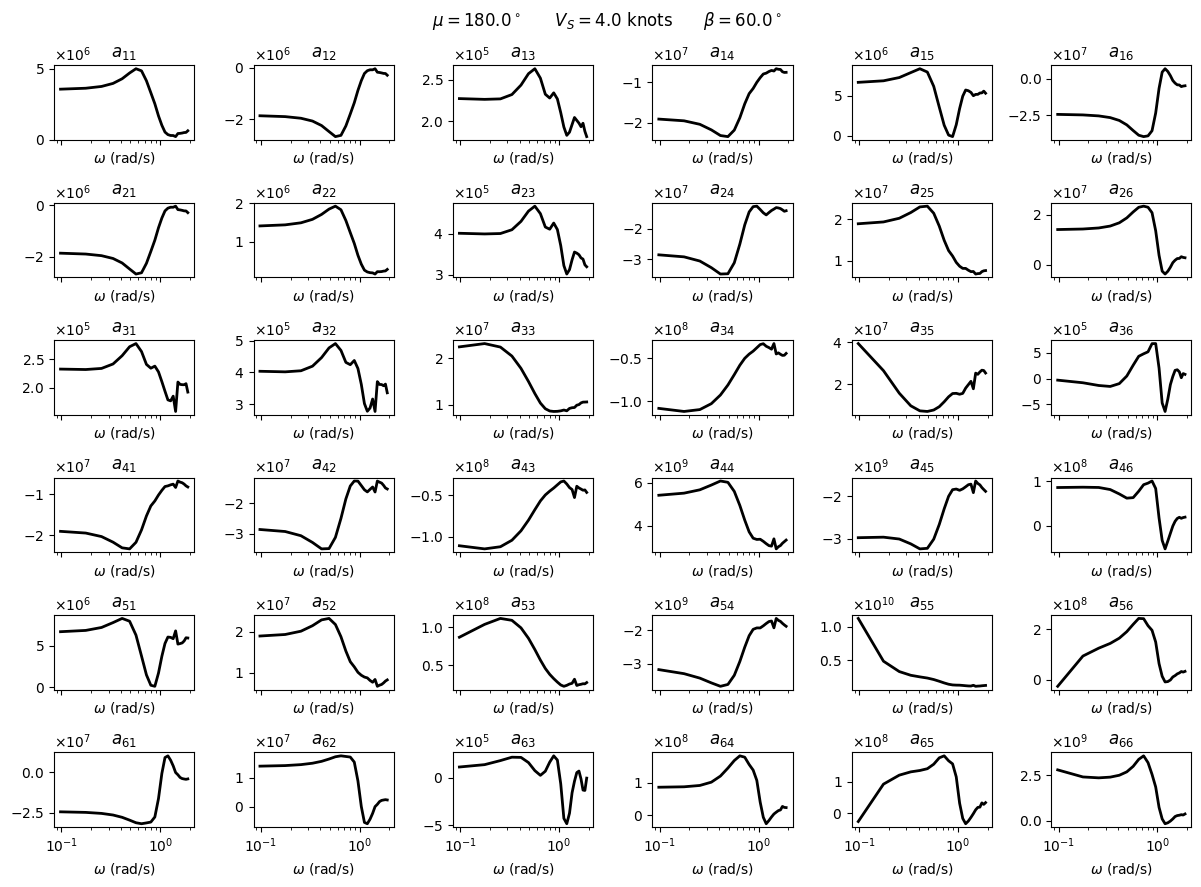

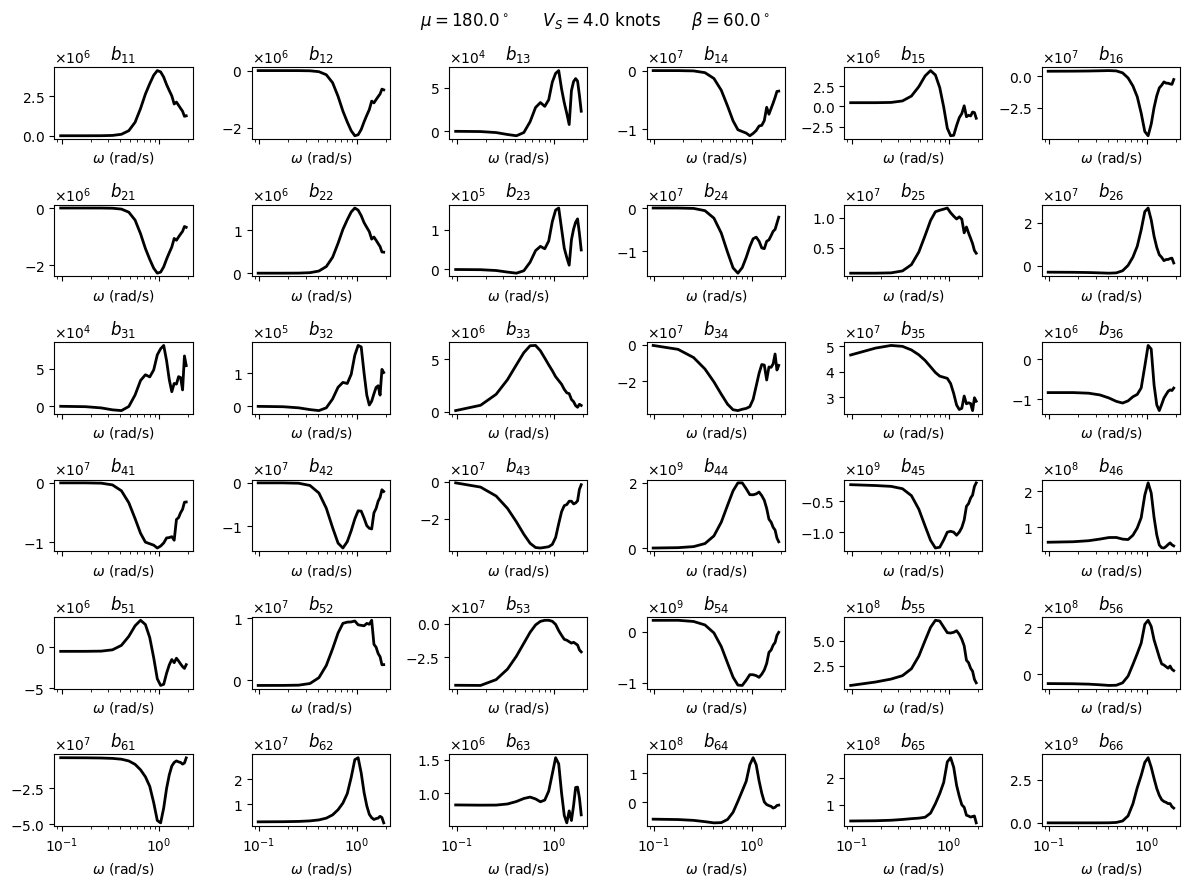

In [7]:
iv,im,ib = 0,0,2

_ = plo_lin(dcon,(iv,im,ib))

## Plotting *A* and *B* coefficients at selected wave angle $\mu$ and vessel speed $V_S$

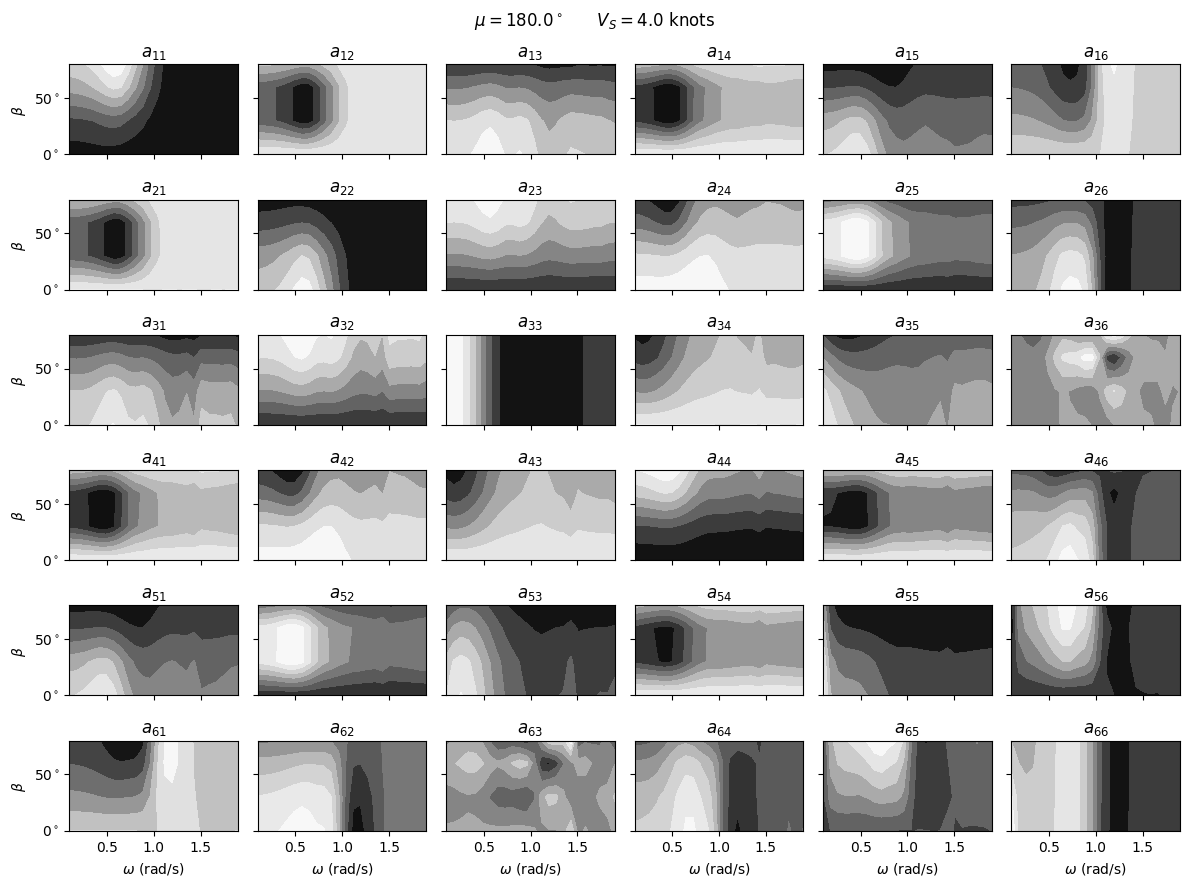

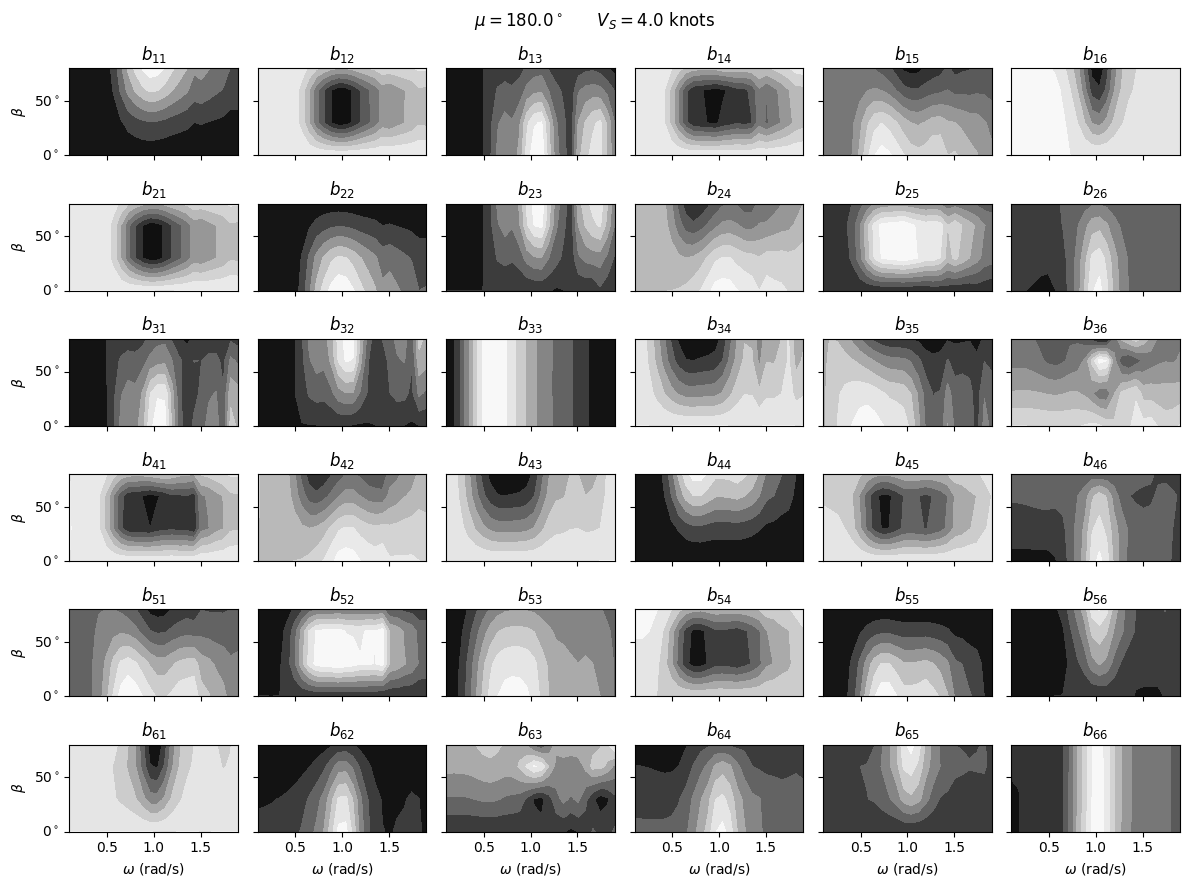

In [8]:
_ = plo_map(dcon,(iv,im),'Greys_r')